## シンプルな例
ウエイト（w）にランダムな入力値(n)をかけた場合と、ウエイトの符号(e)をかけた場合とで値を比較してみましょう。

In [45]:
import numpy as np

w = np.array([-0.4, 0.5, -0.2, 0.4, -0.3, 0.6, -0.4, 0.1, -0.9, 0.7])
n = np.array([-1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0]) # Random
e = np.sign(w)

print('e:', e)
print('w dot n:', np.dot(w, n))
print('w dot e:', np.dot(w, e))

e: [-1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
w dot n: 0.3
w dot e: 4.5


## 敵対的サンプルの作成

ここでは、０から９のOCRイメージをmulticlass logistic regressionによって分類するモデルに対して、敵対的サンプルの作成を行います。

## 目次

* データとパッケージの読み込み
* 攻撃用のメソッドとクラス
* モデルを訓練する
* Non-Targeted-Attack: 
    * 正しいラベルへ分類されないようにする
    * 間違えやすい数
*　傾きの符号をとる
* まとめ

## パッケージの読み込み

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread, imshow

## データの読み込み、内容の確認

今回使うデータを読み込み、その先頭の内容を確認します。

In [6]:
from subprocess import check_output
print(check_output(["ls", "input/digit-recognizer"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



In [4]:
df = pd.read_csv("input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## データの構造
ラベル（label）は、数字の０~９を表します。pixcel0からpixcel783は、２８×２８の画像の値を表します。
例えば、pixel31画像の上から２行目、左から４番目の画像の値を表します。28×(2-1)+(4-1)=31
画像の値は、０~２５５で、値が少ない方がより明るく、多い方がより暗いことを表します。

yはラベルの値とします。
Xは、データdfからlabelの列を削除したものとします。
そして、Xとyを訓練用データとテストデータに区分します。全体の４０％をテストデータとします。

In [10]:
y = df.label.values
X = df.drop("label",axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

テスト用データの最初の１５文字の内容を見てみましょう。

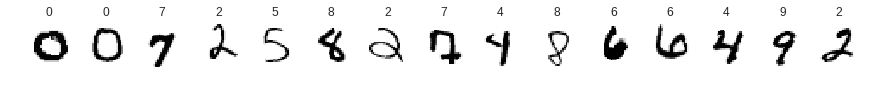

In [11]:
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X_test[i].reshape((28,28)))
    ax1[i].axis('off')
    ax1[i].set_title(y_test[i])

一部、人間にとっても判別しずらい文字があるようです。

## コード　attack用の関数とクラス

### Attack用関数

In [12]:
def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def targeted_gradient(foolingtarget, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(output)):
        if k == 0:
            gradient = foolingtarget[k] * (w[k]-ww)
        else:
            gradient += foolingtarget[k] * (w[k]-ww)
    return gradient

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient

def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

### Attack用クラス
クラスの初期化時に__init__でモデルを読み込みます。
prepareメソッドで、モデルの訓練およびテストを行います。

In [13]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model
    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
        
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = accuracy_score(y_test, self.preds)
    
    def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        score = accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon

    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
        
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            print("calling attack with epsilon:",epsilon)
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)
        

## モデルを訓練する

multiclass logistic regression　のモデルを用意します。

In [14]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

用意したmodelをAttackクラスに渡して、Attackクラスのインスタンスを作成します。そして、prepareメソッドでモデルの訓練およびテストを行いまます。その際にテストデータを使った、当初のaccuracyを取得します。このスコアを後にテストデータにノイズを加えることにより低下させます。

In [15]:
attack = Attack(model)
attack.prepare(X_train, y_train, X_test, y_test)

Model training finished.
Model testing finished. Initial accuracy score: 0.91380952381


約９０％のデータが正しく分類されているようです。
attack.imagesは、テスト用の画像データを表します。テストデータは１６８００あり、それそれ２８×２８＝７８４画素あります。

In [16]:
attack.images.shape

(16800, 784)

attack.weightsは、モデルの重み（係数）を表します。各カテゴリーごとに画素数と同じ数の重みがあります。

In [17]:
weights = attack.weights
weights.shape

(10, 784)

訓練用のデータに含まれるユニークなラベルの数は１０となっています。

In [18]:
num_classes = len(np.unique(y_train))
num_classes

10

## 正しいラベルへ分類されないようにする（Non-targeted Attack）


### ノイズ（摂動、画素の濃淡のずれ）を加える

まず、テストデータのイメージに加えるノイズ（摂動、画素の濃淡のずれ）を計算します。ノイズは、それぞれの画素を少しだけ変化させたときに、画像の正解との不一致がどの程度大きくなるかという値（gradient）を画素毎に計算して、gradientの最大値が１となるように調整を行った上で、それに一定の係数（epsilon）を乗じて計算しています。結果として、各画素における濃淡のずれの最大値はepsilonとなります。係数（epsilon）を０〜２９まで変化させて、accuracyがどのように変化するかを記録します。

In [19]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_gradient, 30)
non_targeted_scores = attack.scores

calling attack with epsilon: 0
calling attack with epsilon: 1
calling attack with epsilon: 2
calling attack with epsilon: 3
calling attack with epsilon: 4
calling attack with epsilon: 5
calling attack with epsilon: 6
calling attack with epsilon: 7
calling attack with epsilon: 8
calling attack with epsilon: 9
calling attack with epsilon: 10
calling attack with epsilon: 11
calling attack with epsilon: 12
calling attack with epsilon: 13
calling attack with epsilon: 14
calling attack with epsilon: 15
calling attack with epsilon: 16
calling attack with epsilon: 17
calling attack with epsilon: 18
calling attack with epsilon: 19
calling attack with epsilon: 20
calling attack with epsilon: 21
calling attack with epsilon: 22
calling attack with epsilon: 23
calling attack with epsilon: 24
calling attack with epsilon: 25
calling attack with epsilon: 26
calling attack with epsilon: 27
calling attack with epsilon: 28
calling attack with epsilon: 29


epsilonとaccuracyをグラフにプロットしてみます。

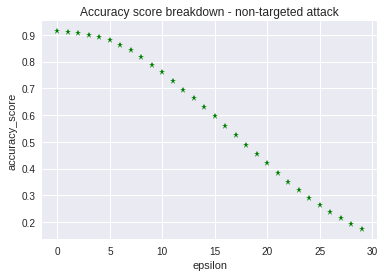

In [21]:
plt.figure()
plt.plot(attack.epsilons, attack.scores, 'g*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - non-targeted attack')

epsilonが１６の時に約４０％が正しく予測されています。epsilonが３０になると、テスト用データにおいて９０％誤って判定されます。epsilonが１６の時の攻撃の状況を詳しくみてみましょう。

In [22]:
eps = 16
attack.epsilons[eps]

16.0

epsilonが１６の時の、ノイズを付加したイメージと、その時の予測結果（ラベル）を取得します。

In [24]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

結果をデータフレームに整理します。y_trueは、テストデータの真のラベルを、y_fooledは、ノイズを付加した画像により予測されたラベルを、y_predictedは、ノイズを付加する前の画像により予測されたラベルを表します。結果の先頭のデータを表示します。

In [26]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,0,0,0,0
1,0,0,0,1
2,7,7,7,2
3,2,2,2,3
4,5,8,5,4


真のラベルと、ノイズ付加により予測されたラベルとが異なるもの（うまくごまかしたもの）をsuccess_dfに保存します。先頭のデータを表示します。

In [27]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
4,5,8,5,4
5,8,4,8,5
6,2,3,3,6
7,7,5,2,7
8,4,9,4,8


うまくごまかしたものの例を１つとって、関連するノイズを付加したイメージをepsilonを変えて表示してみましょう。 

In [28]:
example_id = success_df.id.values[0]
example_id

4

trueは真のラベルを、fooledはノイズを付加したイメージによるモデルの予測値を表します。

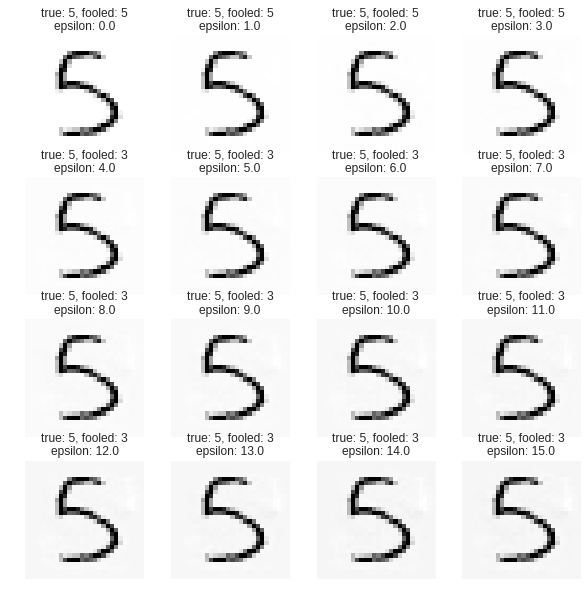

In [29]:
fig2, ax2 = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)))
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(epsilon))

人間の目ではごまかした画像でも本物のように見えます！！。 一方で背景が濃くなっていることが判ります。epsilon が１６の時の実際の画像と、ごまかした画像との差をみてみましょう。

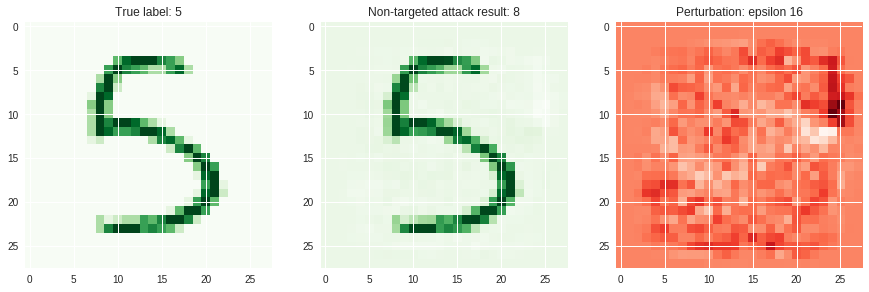

In [31]:
fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,5))
axB.imshow(example_images[example_id].reshape((28,28)), cmap='Greens')
axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
axA.imshow(X_test[example_id].reshape((28,28)), cmap='Greens')
axA.set_title("True label: " + str(y_test[example_id]))
axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)), cmap='Reds')
axC.set_title("Perturbation: epsilon 16")

### 間違えやすい数

数字同士が似ているために、例えば本当は３なのにモデルが８であると誤って判定してしまうというように、攻撃によって結果として「誤って判定されやすい数」というものはあるのでしょうか。モデルの特性や訓練データの特性により、数字同士の判定の境界が適切でないために、訓練したモデル自体のがもともと、入力に対して誤って判定する領域をもっていることもありそうです。攻撃によって誤って判定を行ったケースで、誤ってどのような数字であると判定したのかを数えてみましょう。

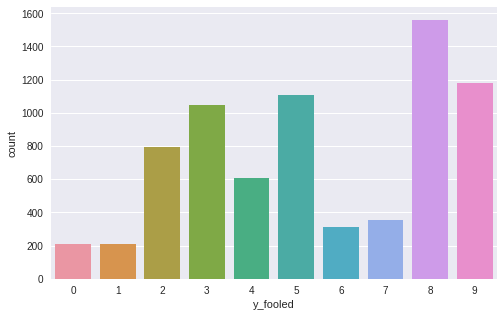

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(x='y_fooled', data=example_results[example_results.y_true != example_results.y_fooled])

攻撃によって、誤って８であると判定されことがもっとも多いようです。９ ， ３ ， ５， ２ であると誤って認識されることも多いようです。一方で、0, 1, 6 , 7 はそうでもないようです。もし、一定の数字がもともと誤って判定する領域をもっているならば、ごまかす前の画像にたいしても同じ傾向が見られるはずです。ごまかす前の画像について、誤ってどのような数であると判定されたかを数えてみましょう。

In [33]:
wrong_predictions = example_results[example_results.y_true != example_results.y_predicted]
wrong_predictions.shape

(1448, 4)

In [34]:
X_test.shape

(16800, 784)

16800のデータのうち約 1600程度がもともと誤って判定されているようです。これは、当初のaccuracyが90 % であることと符合しします。それでは、どのような数字が誤りやすいのでしょうか。結果としてどのような数字であると誤認識されているでしょうか。

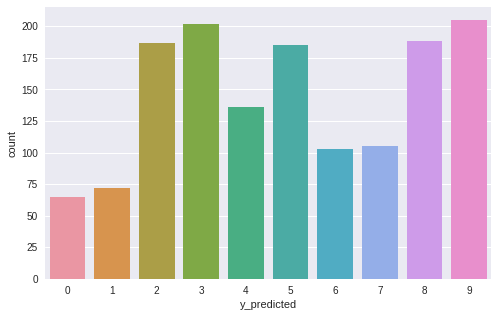

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(x='y_predicted', data=wrong_predictions)

やはり似た傾向がみられます。数字の誤認識は、モデル自体がもつ、数字同士を判定する境界設定の難しさに由来する部分があるようです。では、正しくはどのような数字であったものが誤認されたのでしょうか。

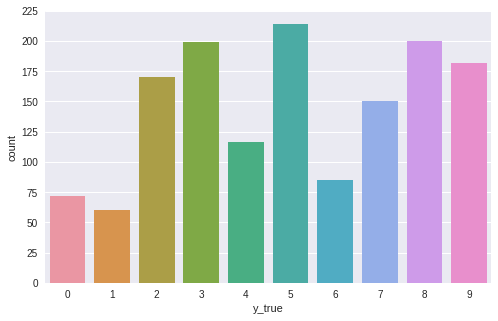

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(x='y_true', data=wrong_predictions)

最後に、正しい数字とごまかされた後の数字との集計をとってみましょう。

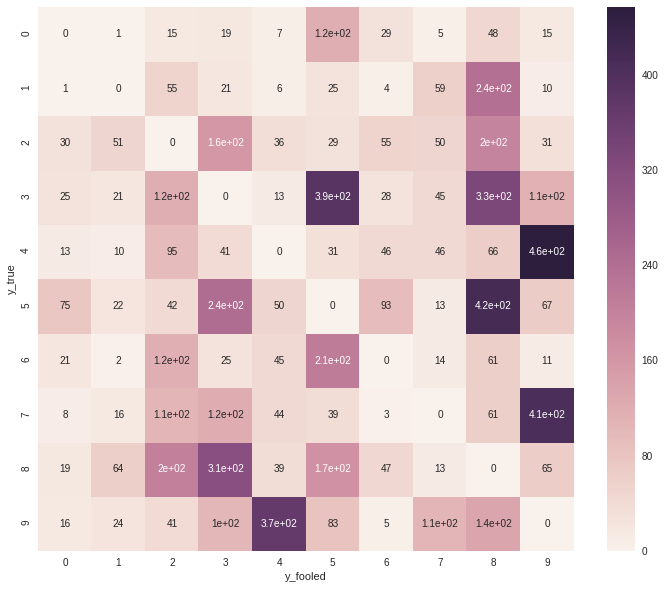

In [37]:
attacktargets = example_results[example_results.y_true != example_results.y_fooled].groupby('y_true').y_fooled.value_counts().unstack()
attacktargets = attacktargets.fillna(0.0)

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(attacktargets, annot=True, ax=ax)

それぞれの数字ごとに、ごまかしやすい相手の数字というものを持っていることが判ります。

## 傾き(gradient)の符号をとる

いままでは、テストデータのイメージに加えるノイズ（摂動、画素の濃淡のずれ）を計算します。ノイズは、それぞれの画素を少しだけ変化させたときに、画像の正解との不一致がどの程度大きくなるかという値（gradient）を画素毎に計算して、gradientの最大値が１となるように調整を行った上で、それに一定の係数（epsilon）を乗じて計算していました。ここでは、gradientのかわりに、gradientの符号（＋１またはー１）を用いてノイズを計算してみましょう。

In [46]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_sign_gradient, 30)

calling attack with epsilon: 0
calling attack with epsilon: 1
calling attack with epsilon: 2
calling attack with epsilon: 3
calling attack with epsilon: 4
calling attack with epsilon: 5
calling attack with epsilon: 6
calling attack with epsilon: 7
calling attack with epsilon: 8
calling attack with epsilon: 9
calling attack with epsilon: 10
calling attack with epsilon: 11
calling attack with epsilon: 12
calling attack with epsilon: 13
calling attack with epsilon: 14
calling attack with epsilon: 15
calling attack with epsilon: 16
calling attack with epsilon: 17
calling attack with epsilon: 18
calling attack with epsilon: 19
calling attack with epsilon: 20
calling attack with epsilon: 21
calling attack with epsilon: 22
calling attack with epsilon: 23
calling attack with epsilon: 24
calling attack with epsilon: 25
calling attack with epsilon: 26
calling attack with epsilon: 27
calling attack with epsilon: 28
calling attack with epsilon: 29


In [1]:
plt.figure()
gm, = plt.plot(attack.epsilons, non_targeted_scores, 'g*', label='gradient method')
gsm, = plt.plot(attack.epsilons, attack.scores, 'r*', label='gradient sign method')
plt.ylabel('accuracy_score')
plt.xlabel('epsilons')
plt.legend(handles=[gm, gsm])
plt.title('Accuracy score breakdown')

NameError: name 'plt' is not defined

符号を用いたほうが、少ないepsilonでaccuracyが低下しています。符号を用いることにより、結果として個々の画素の全てにepsilonだけ符号方向にずれが生じることになるため、同じepsilonで比較した場合には、符号を用いる方が当然誤差が大きくなります。この方法は、発見されないための濃淡のずれの最大値というものがあり、その範囲内で調整する必要があるという場合に、有効な手法であると考えられます。あるいは、同じだけaccuracyを低下させるために必要な最大の濃淡のずれをより少なくできると考えることもできます。

# まとめ

1. モデルの構造やウエイトを知ることができる場合には、ターゲットとモデルの出力と正解との違いをを最大化するように、画像（入力）に変化を加えることにより、モデルに間違った判定をさせることができる。(モデルの構造やウエイトを知らない場合でも、可能ですが、それは別のトピックになります。)
2. 間違いは、モデルが判定の境界をうまく設定することができないことにより生じる。これは、モデルの構造や柔軟性、あるいは、モデル作成のための入力データの質や処理方法により左右される。
3. モデルが判定の境界を設定する際に、特定のカテゴリ（数字）相互に境界が近いものがあるために、もともと間違いやすい数字あるいは数字の組み合わせがある。
4. 傾きの符号をとることにより、一定の条件を満たす場合に、効果的にモデルをだますことができる。
5. このような攻撃は、ネットワークの線形性に由来しているものである。画像のカテゴリ分けだけでなく、より幅広い分野で応用される可能性が高いので注意が必要である。